This is the first draft of the Gaussian Likelihood compressor, a tool which takes some data as an input, and compresses them to a lower dimensional space where the likelihood is simply Gaussian.

In this notebook, you can find 3 tools: first of all, a way to generate the data in order to perform your experiments. 

Then, a compressor, which at this stage could either be an auto-encoder, an Information Maximising Neural Network, or Score Compression in all its various forms.

Finally, we apply a Normalising Flow to map it to a standard Gaussian.

# Data generation

In [1]:
# we write here the script to create our dataset, taken primarily from zupcx26 code
# we will add modules to import progressively 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
lower = np.array([0.15, 0.55])
upper = np.array([1.10, 1.10])
prior = priors.Uniform(lower, upper)

In [3]:
# we define a few hyper parameters here
np.random.seed(13)
n = 1000 # total number of data points for NF
n_sims = n  # total number of points for drawing
n_class = 1 # number of different cosmologies for the training

In [4]:
# load the parameters, \Omega_M and \sigma_8
parameters = np.loadtxt('./power_spectra/parameters_rep_wider.txt')[:n_sims]
#from scipy.spatial import distance
#print(parameters.shape)
#print(np.reshape(q_fid, [-1, 1]).shape)
#print(distance.cdist(np.reshape(q_fid, [1, -1]), parameters).min(axis=1))
#index = np.argmin(distance.cdist(np.reshape(q_fid, [1, -1]), parameters))
#print(parameters[index])

In [5]:
# in order to perform the compressions, we need a few things
n_vec = 49
q_fid = [0.5, 0.7]
Cl_fid = np.loadtxt('./power_spectra/der_power_spectrum_0.dat')[2:, 1]
mu = np.asarray(Cl_fid)
Cinv = (2*np.arange(n_vec)+1) * np.eye(n_vec)/ (2*Cl_fid**2)
# now with the derivatives
mu_p1 = np.loadtxt('./power_spectra/der_power_spectrum_1.dat')[2:, 1]
mu_p2 = np.loadtxt('./power_spectra/der_power_spectrum_2.dat')[2:, 1]
h = 0.01
dmudt = np.zeros([2, n_vec])
dmudt[0] = (mu_p1 - mu)/h
dmudt[1] = (mu_p2 - mu)/h
#dmudt = np.reshape(dmudt, [2, -1])

# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [6]:
Cinv

array([[3.04012998e+16, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.37107766e+17, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.05482464e+17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.29669932e+22, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.76843092e+22, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.28464187e+22]])

In [12]:
# we now create the data needed for the normalising flow
# we create the observed data point, for now at the fiducial value of q
#q_fid = q_fid  # new observation, different from the compression
np.random.seed(13)
q_obs = [0.5, 0.7] #np.loadtxt('./power_spectra/parameters_rep_wider.txt')[n_sims]
d_vec_obs = np.zeros((1, n_vec)) 
for index in range(1):
    load = np.loadtxt('./power_spectra/der_power_spectrum_0.dat') #np.loadtxt('./power_spectra/power_spectrum_1000.dat')[2:, 1]
    cls = load[:, 1]
    single = []
    for ell in range(2, lmax+1):
        shape = (2*ell+1)/2
        location = 2*cls[ell]/(2*ell+1)
        single.append(np.random.gamma(shape, location))
    d_vec_obs[index] = single
d_vec_obs = np.reshape(d_vec_obs, [1, -1])

lmax = 50
# we also create the data for the training
d_vec_q = np.zeros((n_sims, n_vec))
power_spectra = []
for index in range(n_sims):
    load = np.loadtxt(f'./power_spectra/power_spectrum_{index}.dat')
    cls = load[:, 1]
    single = []
    for ell in range(2, lmax+1):
        shape = (2*ell+1)/2
        location = 2*cls[ell]/(2*ell+1)
        single.append(np.random.gamma(shape, location))
    d_vec_q[index] = single
    
d_vec_obs_keep = np.copy(d_vec_obs)
print(d_vec_q.shape, d_vec_obs.shape)

(1000, 49) (1, 49)


In [13]:
d_vec_obs

array([[2.07334966e-09, 3.38208701e-09, 1.59593485e-09, 1.50868781e-09,
        1.62987132e-09, 1.09827228e-09, 1.09088902e-09, 3.99139940e-10,
        5.90019081e-10, 3.80717301e-10, 4.63140349e-10, 3.48104614e-10,
        2.94870934e-10, 4.25234907e-10, 1.79276422e-10, 2.76469850e-10,
        1.85089198e-10, 1.85149171e-10, 2.16838775e-10, 1.02323389e-10,
        1.52262917e-10, 1.84432409e-10, 1.04138182e-10, 1.00728719e-10,
        1.11334676e-10, 7.11139501e-11, 8.51578270e-11, 1.04158299e-10,
        1.10018620e-10, 7.42460661e-11, 5.95038658e-11, 6.71674599e-11,
        6.86396527e-11, 5.69242016e-11, 7.09623263e-11, 7.42458859e-11,
        5.46365796e-11, 4.51792357e-11, 3.39571928e-11, 3.95309720e-11,
        4.55910517e-11, 4.66167118e-11, 3.76492227e-11, 3.51184583e-11,
        3.09255921e-11, 3.03727421e-11, 2.88129231e-11, 3.34773759e-11,
        2.71337857e-11]])

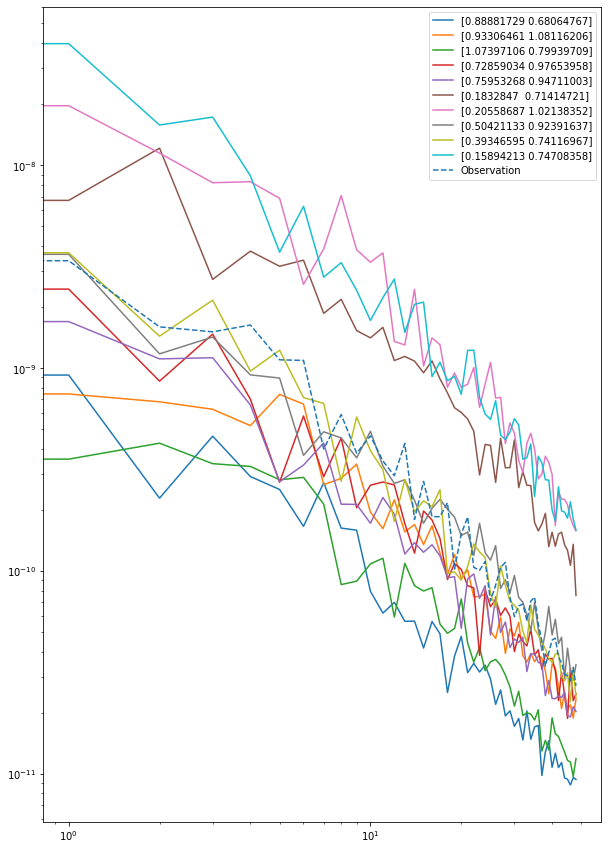

In [14]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in range(10):
    plt.loglog(np.arange(n_vec), d_vec_q[index], label=parameters[index])
#for index in range(n):
#    plt.plot(np.arange(n_vec), d_vec[index],)
plt.loglog(np.arange(n_vec), d_vec_obs[0], label='Observation', linestyle='--')
plt.legend();

In [15]:
# we need to retrieve all the needed summaries here, so:
# 1) the summary of the observation
# 2) the summaries of the noise realisations
summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(d_vec_q[index]))
summaries_noise = np.asarray(summaries_noise)
summary_obs = compressor(d_vec_obs[0])
summary_obs = np.reshape(summary_obs, [1, -1])

In [16]:
compressor(d_vec_obs[0])

array([0.0736716 , 0.58779673])

In [17]:
compressed_data = summary_obs[0]

sim_params = parameters #np.reshape(q_prior, [-1, 1])

sim_compressed_data = summaries_noise

#Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array(q_fid)

## Create ensemble of NDEs


In [18]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=2, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]

## Create DELFI object

In [19]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,  
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\Omega_m', 'S_8'], 
                            results_dir = "./attempt_results")

## Load simulations into DELFI object

In [20]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

# Train the networks

In [21]:
DelfiEnsemble.train_ndes()

In [22]:
# this should give us the log-likelihood
n_bins = 50
xx = np.linspace(0.15, 1.10, n_bins, endpoint=True) #np.random.uniform(0, 1, n)
yy = np.linspace(0.55, 1.10, n_bins, endpoint=True) #np.random.uniform(0, 1, n)
xv, yv = np.meshgrid(xx, yy)
likelihood_arr = np.zeros((n_bins*n_bins, 3))
index = 0
for omega in xx:
    for es in yy:
        likelihood_arr[index, :] = omega, es, DelfiEnsemble.log_likelihood_stacked([omega, es], compressed_data)
        index += 1

In [23]:
likelihood_arr

array([[  0.15      ,   0.55      ,  -3.34462786],
       [  0.15      ,   0.56122449,  -3.44983244],
       [  0.15      ,   0.57244898,  -3.54317236],
       ...,
       [  1.1       ,   1.07755102, -18.73049545],
       [  1.1       ,   1.08877551, -17.73311806],
       [  1.1       ,   1.1       , -16.78623581]])

In [24]:
likelihood_arr = np.reshape(np.asarray(likelihood_arr), (-1, 3))
likelihood_arr[:, 2] = np.exp(likelihood_arr[:, 2])  # return to likelihood
like_norm = np.sum(likelihood_arr[:, 2])
likelihood_arr[:, 2] = likelihood_arr[:, 2] / like_norm

In [25]:
omega_m_obs, S8_obs = q_obs[0], q_obs[1]

In [26]:
# we retrieve the real posterior here
# a few things that will be useful later on
from scipy.stats import gamma
ell = np.arange(2, lmax+1)
shape = (2*ell+1)/2

likelihood_arr_true = np.zeros((n_bins*n_bins, 3))
index = 0

# and we evaluate the likelihood here
for i in xx:
    for j in yy:
        load = np.loadtxt(f'./power_spectra/power_spectrum_{i}_{j}.dat')
        cls = load[:, 1]
        scale = 2*cls[ell]/(2*ell+1)
        evaluation = gamma.pdf(x=d_vec_obs[0], a=shape, loc=0, scale=scale)  # the scipy gamma distribution has a slightly different definition than the numpy one
        likelihood = np.prod(evaluation/3e12)
        likelihood_arr_true[index, :] = i, j, likelihood
        index += 1
like_norm_true = np.sum(likelihood_arr_true[:, 2])
likelihood_arr_true[:, 2] = likelihood_arr_true[:, 2] / like_norm_true

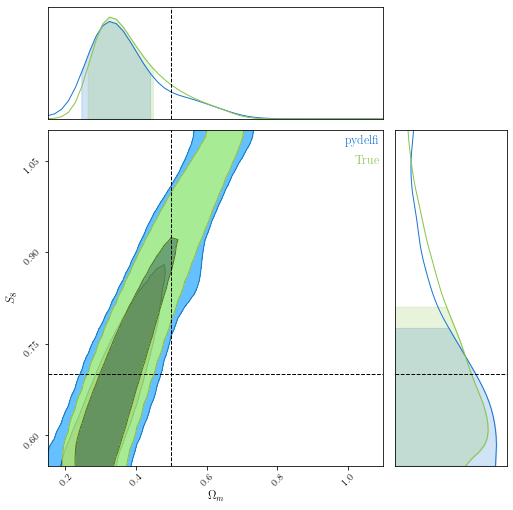

In [28]:
from chainconsumer import ChainConsumer
xs = likelihood_arr[:, 0]
ys = likelihood_arr[:, 1]
#ys = ys/np.sqrt(xs/0.3)
pdf_flat = likelihood_arr[:, 2]

xs_true = likelihood_arr_true[:, 0]
ys_true = likelihood_arr_true[:, 1]
#ys = ys/np.sqrt(xs/0.3)
pdf_flat_true = likelihood_arr_true[:, 2]

c = ChainConsumer()
c.add_chain([xs, ys], parameters=["$\Omega_m$", "$S_8$"], weights=pdf_flat, grid=True, name='pydelfi')
c.add_chain([xs_true, ys_true], parameters=["$\Omega_m$", "$S_8$"], weights=pdf_flat_true, grid=True, name='True')
c.configure(smooth=2)  # Notice how smoothing changes the results!
fig = c.plotter.plot(truth=[omega_m_obs, S8_obs])

fig.set_size_inches(4.5 + fig.get_size_inches())  

In [18]:
import scipy.special as sps
theo_post = np.zeros((n_bins, 2))
for i, q in enumerate(sim_params):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

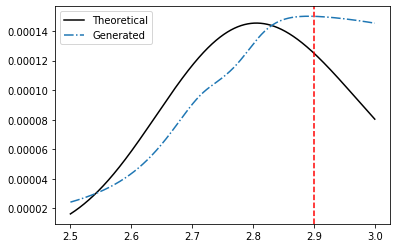

In [19]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')